In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Fado")
import ast
import scipy.io
import cftime
import pickle
import shutil
from pathlib import Path

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
Data_directory = parent_directory + '/Data/'
NC_directory = parent_directory + '/Data/NCFiles/Historical/'

In [3]:
def CheckCoordinate(lat , lon):
    location = geolocator.reverse((lat, lon-360), exactly_one=True)
    if location:
        address = location.raw.get("address", {})
        state = address.get("state")
        if state and (state.lower() == "texas" or state.lower() == "tx"):
            county = address.get("county")
            return True , county
    return False , 0

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
Data_directory = os.path.join(parent_directory, 'Data/NCFiles/Historical/')

dataHR = xr.open_dataset(Data_directory+'CESM_HR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc')
lat_Value_HR = dataHR.coords['lat'].values
lon_Value_HR = dataHR.coords['lon'].values

dataLR = xr.open_dataset(Data_directory+'CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc')
lat_Value_LR = dataLR.coords['lat'].values
lon_Value_LR = dataLR.coords['lon'].values

dataHR.close()
dataLR.close()

In [5]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
Data_directory = parent_directory + '/Data/'
NC_directory = parent_directory + '/Data/NCFiles/Historical/'

In [6]:
## Create Bias Correction df - ind: lon and col: lat
mat_data = scipy.io.loadmat(NC_directory + '/bias_correct_coefficients.mat')

bc_HR = mat_data['bc_HR']
bc_HR_df = pd.DataFrame(bc_HR)
bc_HR_df.columns = lat_Value_HR
bc_HR_df = bc_HR_df.set_index(lon_Value_HR)

bc_LR = mat_data['bc_LR']
bc_LR_df = pd.DataFrame(bc_LR)
bc_LR_df.columns = lat_Value_LR
bc_LR_df = bc_LR_df.set_index(lon_Value_LR)

In [7]:
print("Filtering data...")
TexasList_dir = Data_directory+'/TexasDict.pkl'
if Path(TexasList_dir).exists():
    with open(TexasList_dir, 'rb') as file:
        TexasList = pickle.load(file)
else:
    TexasList = {}
    for lat_val in lat_Value_HR:
        for lon_val in lon_Value_HR:
            if 25<=lat_val<=38 and -107<=lon_val-360<=-92:
                key = (lat_val , lon_val)
                status , county = CheckCoordinate(lat_val , lon_val)
                if status:
                    TexasList[key] = [county]
                    print((lat_val , lon_val),' Exists! and in: ',county)
    with open(TexasList_dir, 'wb') as file:
        pickle.dump(TexasList, file)

Filtering data...


In [8]:
##Convert Historical Data into a DataFrame
filename = parent_directory + '/Data/NCFiles/Historical/Real/ERA5_WindSpeed100m_2000_2020.nc'
print('Processing: ' + filename)
datasetHist = xr.open_dataset(filename)
#lat_Value_Hist = datasetHist.coords['latitude'].values
#lon_Value_Hist = datasetHist.coords['longitude'].values

Processing: /scratch/user/fatemehdoudi/Archive/WindDroughtProject/Data/NCFiles/Historical/Real/ERA5_WindSpeed100m_2000_2020.nc


In [9]:
WSPD_dict = {'LR':[] , 'HR':[] , 'Hist':[]}
for key , county in TexasList.items():
        Lat_val = key[0]
        Lon_val = key[1]
        data = ((datasetHist['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest'))).values
        WSPD_dict["Hist"].append(data)

In [11]:
print(bc_LR_df)

           25.0      26.0      27.0      28.0      29.0      30.0      31.0  \
230.0  1.032374  1.021691  1.010009  1.000134  0.983902  0.971096  0.958153   
231.0  1.036159  1.027555  1.015035  1.003721  0.988155  0.972140  0.960888   
232.0  1.040609  1.035108  1.021788  1.009411  0.993281  0.979252  0.967335   
233.0  1.047004  1.040470  1.027018  1.013305  0.999623  0.983265  0.969035   
234.0  1.049760  1.041955  1.026605  1.014652  1.002935  0.985651  0.972502   
...         ...       ...       ...       ...       ...       ...       ...   
298.0  1.047226  1.065887  1.072611  1.083948  1.086433  1.081247  1.076018   
299.0  1.043755  1.055152  1.067507  1.087216  1.086738  1.085243  1.082411   
300.0  1.039391  1.047184  1.059744  1.082889  1.085072  1.082399  1.084548   
301.0  1.034491  1.042555  1.054158  1.075820  1.083158  1.085389  1.084091   
302.0  1.028201  1.035071  1.051181  1.064852  1.080739  1.094712  1.087874   

           32.0      33.0      34.0  ...      41.0 

In [12]:
file_list = os.listdir(NC_directory)
for filename in file_list:
    full_path = NC_directory + filename
    if filename.lower().endswith('.nc'):
        dataset = xr.open_dataset(full_path)
        if 'LR' in filename:
                key = 'LR'
        elif 'HR' in filename:
                key = 'HR'
        print('Processing: ' + filename+'...')
        for keyC , county in TexasList.items():
            Lat_val = keyC[0]
            Lon_val = keyC[1]
            if 'LR' in filename:
                if Lon_val%1 == 0 and Lat_val%1 == 0 :
                    Coefficient = bc_LR_df.loc[(Lon_val) , (Lat_val)]
                    data = (((dataset['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest'))).values)*Coefficient
                    WSPD_dict[key].append(data)
            elif 'HR' in filename:
                Coefficient = bc_HR_df.loc[(Lon_val) , (Lat_val)]
                data = (((dataset['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest'))).values)*Coefficient
                WSPD_dict[key].append(data)

Processing: CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc...
Processing: CESM_HR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc...
Processing: CESM_HR_RCP85_ENS02_Climate-Power_CONUS_20002020.nc...
Processing: CESM_LR_RCP85_ENS02_Climate-Power_CONUS_20002020.nc...


In [13]:
merged_array_LR = np.concatenate(WSPD_dict["LR"], axis=0)
merged_array_HR = np.concatenate(WSPD_dict["HR"], axis=0)
merged_array_Hist = np.concatenate(WSPD_dict["Hist"], axis=0)

flattened_data_LR = np.ravel(merged_array_LR)
flattened_data_HR = np.ravel(merged_array_HR)
flattened_data_Hist = np.ravel(merged_array_Hist)

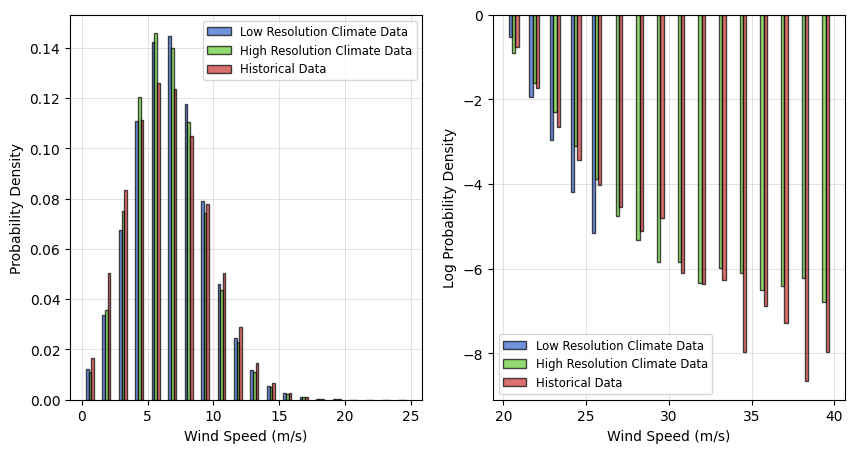

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have three arrays representing wind speed data
# Replace these with your actual data
wind_speed_array1 = flattened_data_LR
wind_speed_array2 = flattened_data_HR
wind_speed_array3 = flattened_data_Hist

# Set the maximum wind speed value you want to consider
max_wind_speed = 0

filtered_array1 = wind_speed_array1[wind_speed_array1 >= max_wind_speed]
filtered_array2 = wind_speed_array2[wind_speed_array2 >= max_wind_speed]
filtered_array3 = wind_speed_array3[wind_speed_array3 >= max_wind_speed]

# Calculate the number of bins
num_bins = 20

# Create a histogram for each filtered array
hist1, bins = np.histogram(filtered_array1, bins=num_bins, range=(0, 25), density=True)
hist2, _ = np.histogram(filtered_array2, bins=num_bins, range=(0, 25), density=True)
hist3, _ = np.histogram(filtered_array3, bins=num_bins, range=(0, 25), density=True)

# Calculate bin centers for x-axis
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Set the width for each bar group
bar_width = 0.2

# Define the x-positions for each bar group
x_positions1 = bin_centers - bar_width
x_positions2 = bin_centers
x_positions3 = bin_centers + bar_width

# Define custom colors with higher saturation and lower brightness
color1 = (0.2, 0.4, 0.8)  # Custom color for LR (e.g., blue)
color2 = (0.4, 0.8, 0.2)  # Custom color for HR (e.g., green)
color3 = (0.8, 0.2, 0.2)  # Custom color for Hist (e.g., red)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Plot the log PDFs for the three arrays with bars next to each other and denser colors
bars1 = plt.bar(x_positions1, hist1, width=bar_width, alpha=0.7, color=color1, edgecolor='k', label='Low Resolution Climate Data')
bars2 = plt.bar(x_positions2, hist2, width=bar_width, alpha=0.7, color=color2, edgecolor='k', label='High Resolution Climate Data')
bars3 = plt.bar(x_positions3, hist3, width=bar_width, alpha=0.7, color=color3, edgecolor='k', label='Historical Data')

plt.xlabel('Wind Speed (m/s)', fontsize=10)
plt.ylabel('Probability Density', fontsize=10)
plt.legend(fontsize='small')

for bar in bars1 + bars2 + bars3:
    bar.set_zorder(2)  # Set bars above the grid lines

plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)  # Set grid lines behind bars


# Assuming you have three arrays representing wind speed data
# Replace these with your actual data
wind_speed_array1 = flattened_data_LR
wind_speed_array2 = flattened_data_HR
wind_speed_array3 = flattened_data_Hist

# Set the maximum wind speed value you want to consider
max_wind_speed = 20

filtered_array1 = wind_speed_array1[wind_speed_array1 >= max_wind_speed]
filtered_array2 = wind_speed_array2[wind_speed_array2 >= max_wind_speed]
filtered_array3 = wind_speed_array3[wind_speed_array3 >= max_wind_speed]

# Calculate the number of bins
num_bins = 20

# Create a histogram for each filtered array
hist1, bins = np.histogram(filtered_array1, bins=num_bins, range=(15, 40), density=True)
hist2, _ = np.histogram(filtered_array2, bins=num_bins, range=(15, 40), density=True)
hist3, _ = np.histogram(filtered_array3, bins=num_bins, range=(15, 40), density=True)

# Calculate bin centers for x-axis
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Set the width for each bar group
bar_width = 0.2

# Define the x-positions for each bar group
x_positions1 = bin_centers - bar_width
x_positions2 = bin_centers
x_positions3 = bin_centers + bar_width

plt.subplot(1, 2, 2)
# Plot the log PDFs for the three arrays with bars next to each other and denser colors
bars1 = plt.bar(x_positions1, np.log(hist1), width=bar_width, alpha=0.7, color=color1, edgecolor='k', label='Low Resolution Climate Data')
bars2 = plt.bar(x_positions2, np.log(hist2), width=bar_width, alpha=0.7, color=color2, edgecolor='k', label='High Resolution Climate Data')
bars3 = plt.bar(x_positions3, np.log(hist3), width=bar_width, alpha=0.7, color=color3, edgecolor='k', label='Historical Data')

plt.xlabel('Wind Speed (m/s)', fontsize=10)
plt.ylabel('Log Probability Density', fontsize=10)
plt.legend(fontsize='small')

for bar in bars1 + bars2 + bars3:
    bar.set_zorder(2)  # Set bars above the grid lines

plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)  # Set grid lines behind bars
plt.show()


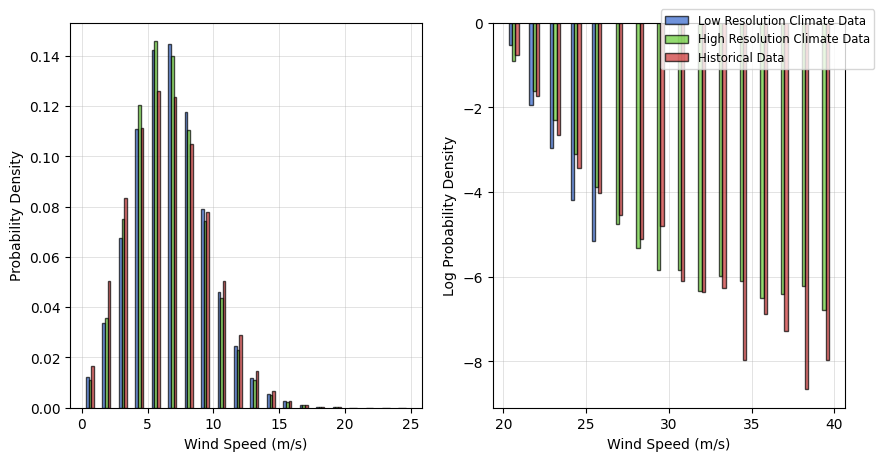

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have three arrays representing wind speed data
# Replace these with your actual data
wind_speed_array1 = flattened_data_LR
wind_speed_array2 = flattened_data_HR
wind_speed_array3 = flattened_data_Hist

# Set the maximum wind speed value you want to consider
max_wind_speed = 0

filtered_array1 = wind_speed_array1[wind_speed_array1 >= max_wind_speed]
filtered_array2 = wind_speed_array2[wind_speed_array2 >= max_wind_speed]
filtered_array3 = wind_speed_array3[wind_speed_array3 >= max_wind_speed]

# Calculate the number of bins
num_bins = 20

# Create a histogram for each filtered array
hist1, bins = np.histogram(filtered_array1, bins=num_bins, range=(0, 25), density=True)
hist2, _ = np.histogram(filtered_array2, bins=num_bins, range=(0, 25), density=True)
hist3, _ = np.histogram(filtered_array3, bins=num_bins, range=(0, 25), density=True)

# Calculate bin centers for x-axis
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Set the width for each bar group
bar_width = 0.2

# Define the x-positions for each bar group
x_positions1 = bin_centers - bar_width
x_positions2 = bin_centers
x_positions3 = bin_centers + bar_width

# Define custom colors with higher saturation and lower brightness
color1 = (0.2, 0.4, 0.8)  # Custom color for LR (e.g., blue)
color2 = (0.4, 0.8, 0.2)  # Custom color for HR (e.g., green)
color3 = (0.8, 0.2, 0.2)  # Custom color for Hist (e.g., red)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Plot the log PDFs for the three arrays with bars next to each other and denser colors
bars1 = plt.bar(x_positions1, hist1, width=bar_width, alpha=0.7, color=color1, edgecolor='k', label='Low Resolution Climate Data')
bars2 = plt.bar(x_positions2, hist2, width=bar_width, alpha=0.7, color=color2, edgecolor='k', label='High Resolution Climate Data')
bars3 = plt.bar(x_positions3, hist3, width=bar_width, alpha=0.7, color=color3, edgecolor='k', label='Historical Data')

plt.xlabel('Wind Speed (m/s)', fontsize=10)
plt.ylabel('Probability Density', fontsize=10)

for bar in bars1 + bars2 + bars3:
    bar.set_zorder(2)  # Set bars above the grid lines

plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)  # Set grid lines behind bars


# Assuming you have three arrays representing wind speed data
# Replace these with your actual data
wind_speed_array1 = flattened_data_LR
wind_speed_array2 = flattened_data_HR
wind_speed_array3 = flattened_data_Hist

# Set the maximum wind speed value you want to consider
max_wind_speed = 20

filtered_array1 = wind_speed_array1[wind_speed_array1 >= max_wind_speed]
filtered_array2 = wind_speed_array2[wind_speed_array2 >= max_wind_speed]
filtered_array3 = wind_speed_array3[wind_speed_array3 >= max_wind_speed]

# Create a histogram for each filtered array
hist1, bins = np.histogram(filtered_array1, bins=num_bins, range=(15, 40), density=True)
hist2, _ = np.histogram(filtered_array2, bins=num_bins, range=(15, 40), density=True)
hist3, _ = np.histogram(filtered_array3, bins=num_bins, range=(15, 40), density=True)

# Calculate bin centers for x-axis
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Set the width for each bar group
bar_width = 0.2

# Define the x-positions for each bar group
x_positions1 = bin_centers - bar_width
x_positions2 = bin_centers
x_positions3 = bin_centers + bar_width

plt.subplot(1, 2, 2)
# Plot the log PDFs for the three arrays with bars next to each other and denser colors
bars1 = plt.bar(x_positions1, np.log(hist1), width=bar_width, alpha=0.7, color=color1, edgecolor='k', label='Low Resolution Climate Data')
bars2 = plt.bar(x_positions2, np.log(hist2), width=bar_width, alpha=0.7, color=color2, edgecolor='k', label='High Resolution Climate Data')
bars3 = plt.bar(x_positions3, np.log(hist3), width=bar_width, alpha=0.7, color=color3, edgecolor='k', label='Historical Data')

plt.xlabel('Wind Speed (m/s)', fontsize=10)
plt.ylabel('Log Probability Density', fontsize=10)

for bar in bars1 + bars2 + bars3:
    bar.set_zorder(2)  # Set bars above the grid lines

plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, zorder=1)  # Set grid lines behind bars

# Set common legend outside the subplots
plt.legend(fontsize='small', loc='upper right', bbox_to_anchor=(1.1, 1.05))

plt.show()
